# NASA Turbofan RUL prediction

## Data extraction

In [96]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

filepath = "dataset/NASA_turbofan_RUL_data.csv"
dataset = pandas.read_csv(filepath, parse_dates=True)

### Drop settings and non informative features columns

According to the instructions these data are stable and can be ignored. Other column are a repetition of the same value, so there is few point in considering them. 

To do this, the variance is calculated for each column. Then, if the variance does not exceed a certain threshold, the column is ignored

drop columns : 
column = op. setting 1, var = 4.784340124242533e-06
column = op. setting 2, var = 8.588540885522267e-08
column = op. setting 3, var = 0.0
column = sensor 01, var = 0.0
column = sensor 05, var = 3.15559657501012e-30
column = sensor 06, var = 1.929279087728537e-06
column = sensor 10, var = 0.0
column = sensor 16, var = 1.926023300177075e-34
column = sensor 18, var = 0.0
column = sensor 19, var = 0.0


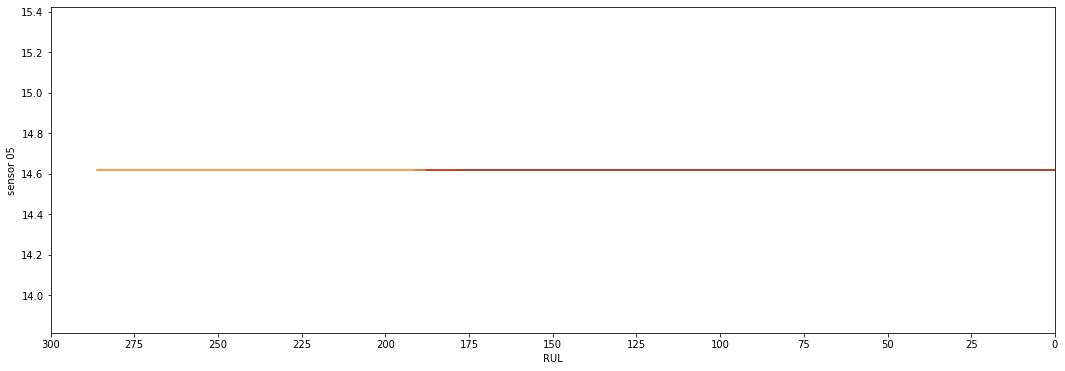

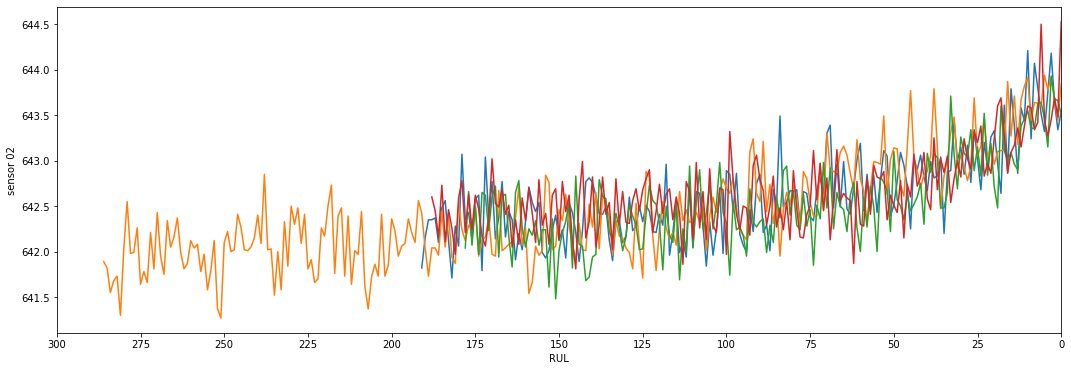

In [97]:
drop_column = []

threshold = 0.0001

print("drop columns : ")
for column in dataset:
    variance = dataset[column].var()
    if threshold > variance:
        print(f"column = {column}, var = {variance}")
        drop_column.append(column)

def PlotSensor(dataset, sensor):
    plt.figure(figsize=(18,6))
    max_rul = 0
    for i in range(1, 5):
        plt.plot('RUL', sensor, data=dataset[dataset['unit number']==i])
        rul = dataset.groupby('unit number')['RUL'].max()[i]
        if rul > max_rul:
            max_rul = rul

    plt.xlim(max_rul, 0)
    plt.xticks(np.arange(0, max_rul+25, 25))
    plt.ylabel(sensor)
    plt.xlabel('RUL')
    plt.show()

PlotSensor(dataset, drop_column[4])

dataset = dataset.drop(columns=drop_column)

PlotSensor(dataset, dataset.columns[2])

## RUL statistics

In [98]:
print(dataset['RUL'].describe())

count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64


## Linear Degradation

In [99]:
nb_engine = np.unique(dataset['unit number']).shape[0]
print(f'number of engine {nb_engine}')

groups = dataset.groupby('unit number')['RUL']
numbers = groups.max()

print('Number of cycle per engine:')
print(numbers)

number of engine 100
Number of cycle per engine:
unit number
1      191
2      286
3      178
4      188
5      268
      ... 
96     335
97     201
98     155
99     184
100    199
Name: RUL, Length: 100, dtype: int64


### Plot degradation

In the first graph (on the left) we can see that the RUL degradation is linear. However, on the dataset, each machine has a different number of RUL and the predictions of the first values may be imprecise at the beginning, then will be refined towards the end. Moreover, the sensors tend to vary more towards the end and the goal here would be to be accurate when the RUL tends towards 0. Therefore, a second degradation idea is proposed (on the right) which consists in cutting the values above a certain number (here 125) to be more accurate on the values between 125 and 0.

The two degradations will be compared later to show the effectiveness of each.

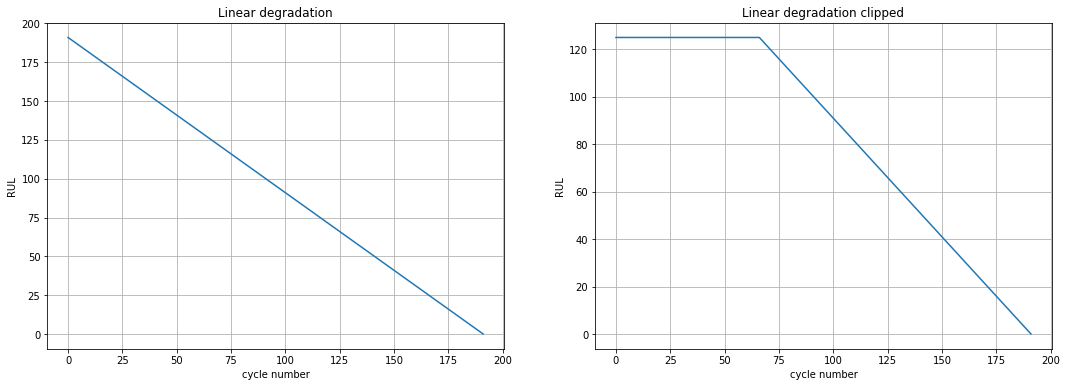

In [100]:
# this value can be changed, but it would affect model accuracy
# after few test 125 seems to be good for this dataset
clip_limit = 125

# test linear degradation
unit = dataset.loc[dataset['unit number'] == 1]
rul = unit['RUL']
cycles = unit['time (cycles)']

# plot test
plt.figure(figsize = (18, 6))
plt.subplot(121)
plt.plot(rul)
plt.title("Linear degradation")
plt.xlabel("cycle number")
plt.ylabel("RUL")

plt.grid()

# clip plot test
rul_clipped = rul.clip(upper=clip_limit)

plt.subplot(122)
plt.plot(rul_clipped)
plt.title("Linear degradation clipped")
plt.xlabel("cycle number")
plt.ylabel("RUL")
plt.grid()

plt.show()

### Scatter plot

Plot linear degradation with prediction

In [101]:
def ScatterPlot(y_pred, y_true, test_size, plot_x):
    plt.figure(figsize = (16, 8))
    plt.scatter(range(test_size), y_pred, label="prediction")
    plt.scatter(range(test_size), y_true, label="y_test")
    plt.legend(loc="upper left")
    plt.show()

    plt.scatter(range(plot_x), prediction[0:plot_x], label="prediction")
    plt.scatter(range(plot_x), y_test[0:plot_x], label="y_test")
    plt.legend(loc="upper left")
    plt.show()

### Print Metrics

Show skleanr metrics 

In [102]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def PrintMetrics(y_train, y_test, prediction):
    mse = mean_squared_error(y_test, prediction)
    mae = mean_absolute_error(y_test, prediction)
    r2 = r2_score(y_test, prediction)

    print(f'Sizes: test={len(y_test)} train={len(y_train)}')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'function R2 Score: {r2}')

## SVR 

Linear regression analysis is used to predict the value of one variable based on the value of another variable.
Linear regression is the determination of a line or surface that reduces the differences between expected and actual output values.

In [103]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Linear regression

Linear regression is the determination of a line or surface that reduces the differences between predicted and actual output values.

#### Data preparation

In [104]:
# Here using X_train with 80 machines will slow down the model considerably. 
# Therefore the train size is reduced as well as the test size to keep a 
# proportion of about 80% train and 20% test.

X_train = dataset.loc[dataset['unit number'] <= 50].drop(columns=['unit number', 'time (cycles)'])
y_train = X_train.pop('RUL')

X_test = dataset.loc[dataset['unit number'] > 90].drop(columns=['unit number', 'time (cycles)'])
y_test = X_test.pop('RUL')

plot_x = dataset.loc[dataset['unit number'] == 91].groupby('unit number').max().reset_index().drop(columns=['unit number'])['RUL'][0]

Sizes: test=2251 train=9909
Mean Squared Error: 4426.809490248244
Mean Absolute Error: 51.81495000592322
function R2 Score: 0.3563113235704166


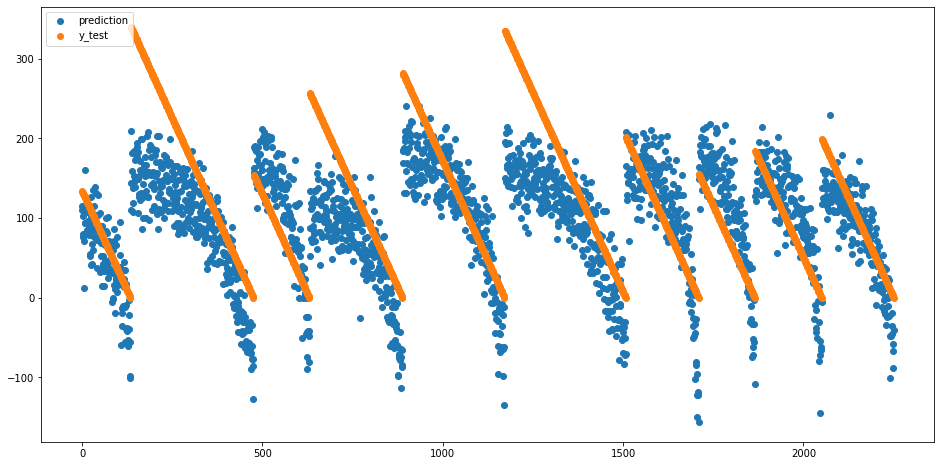

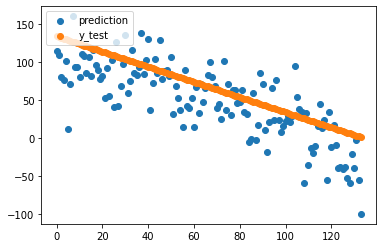

In [105]:

regressor = SVR(kernel="linear")
regressor.fit(X_train, y_train)
prediction = regressor.predict(X_test)

PrintMetrics(y_train, y_test, prediction)
ScatterPlot(prediction, y_test, len(y_test), plot_x)

### Linear regression with clipped value

SVR is again used with clipped values to increase the accuracy when the RUL value tends to 0. Moreover, we notice on the first model that the first values are not very accurate, so cutting it voluntarily will not degrade the prediction results

y_test
Sizes: test=2251 train=9909
Mean Squared Error: 5456.427964521791
Mean Absolute Error: 54.7451881321531
function R2 Score: 0.20659768570265713


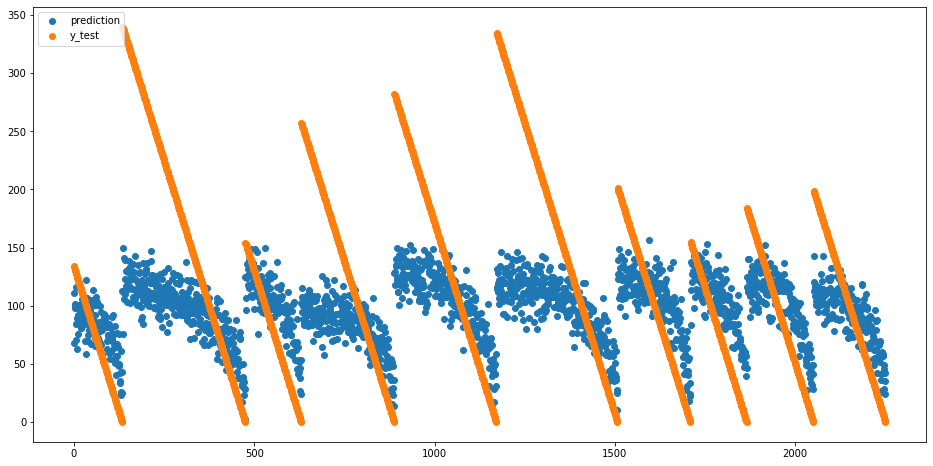

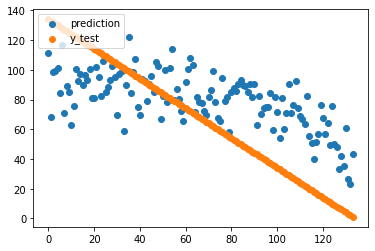


-------------

y_test_clipped
Sizes: test=2251 train=9909
Mean Squared Error: 811.7244692864601
Mean Absolute Error: 23.187671382150004
function R2 Score: 0.5233899041438121


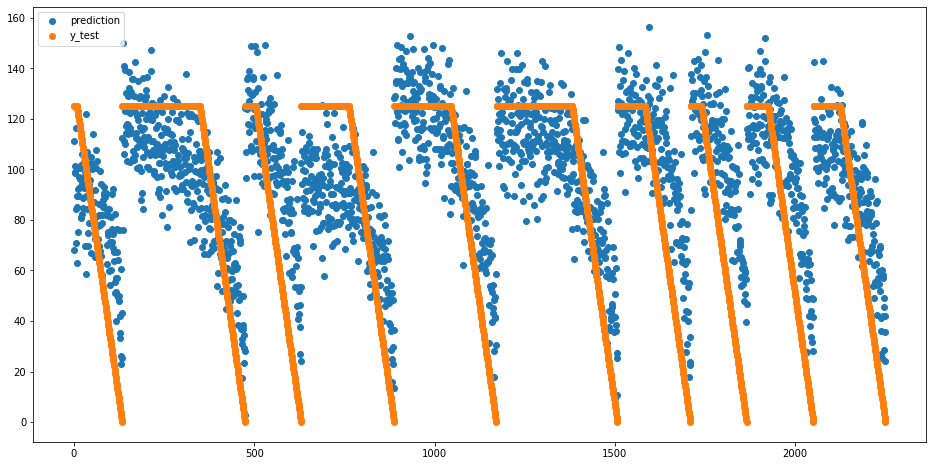

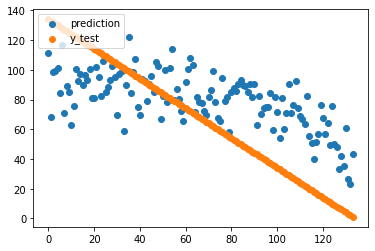

In [106]:
y_train_clipped = y_train.clip(upper=clip_limit)

regressor = SVR(kernel="linear")
regressor.fit(X_train, y_train_clipped)
prediction = regressor.predict(X_test)

print("y_test")
PrintMetrics(y_train_clipped, y_test, prediction)
ScatterPlot(prediction, y_test, len(y_test), plot_x)

print("\n-------------\n")

# y_test clipped clontarly to see in more detail. Of course this is not the case in real life.
print("y_test_clipped")
PrintMetrics(y_train_clipped, y_test.clip(upper=clip_limit), prediction)
ScatterPlot(prediction, y_test.clip(upper=clip_limit), len(y_test), plot_x)

### Linear regression with scaling and y_train clipped

Transform features by scaling each feature to a given range. MinMaxScaler scales and translates each feature individually such that it is in the given range on the training set, here between zero and one.

The result of the predictions increases considerably as shown in the following graphs

y_test
Sizes: test=2251 train=9909
Mean Squared Error: 5311.724884514209
Mean Absolute Error: 50.15670446254946
function R2 Score: 0.22763851301870708


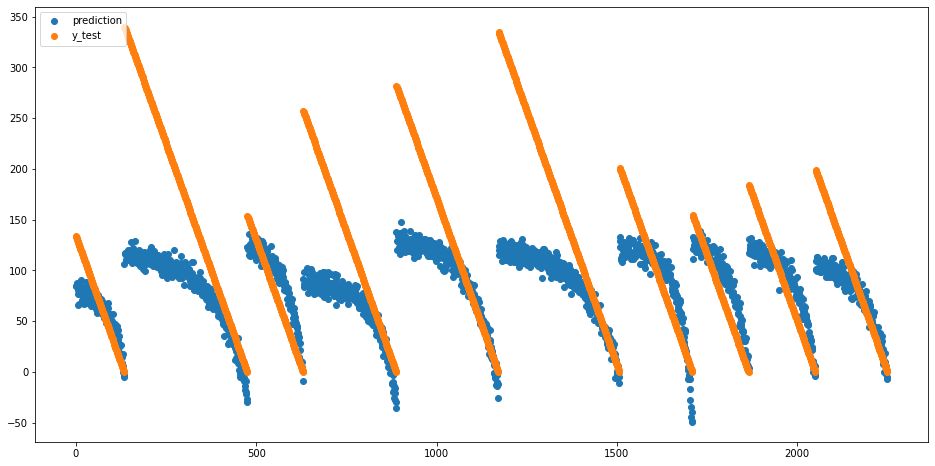

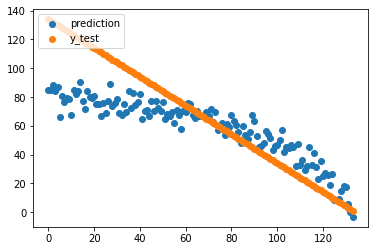


-------------

y_test_clipped
Sizes: test=2251 train=9909
Mean Squared Error: 458.5318327413449
Mean Absolute Error: 17.313932266614604
function R2 Score: 0.730769603449219


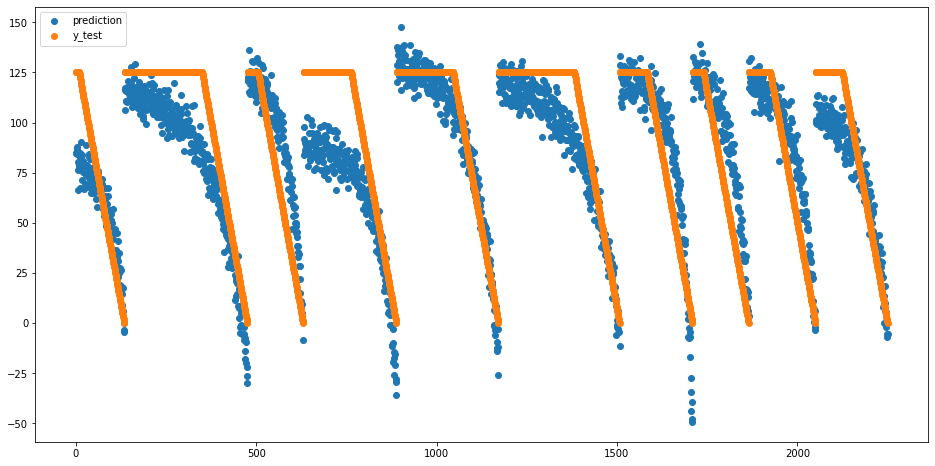

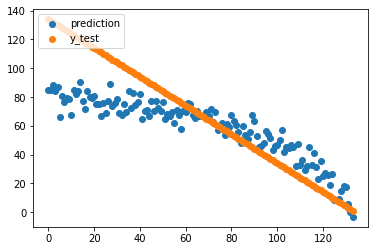

In [107]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

regressor = SVR(kernel='linear')
regressor.fit(X_train_scaled, y_train_clipped)
prediction = regressor.predict(X_test_scaled)

print("y_test")
PrintMetrics(y_train_clipped, y_test, prediction)
ScatterPlot(prediction, y_test, len(y_test), plot_x)

print("\n-------------\n")

# y_test clipped clontarly to see in more detail. Of course this is not the case in real life.
print("y_test_clipped")
PrintMetrics(y_train_clipped, y_test.clip(upper=clip_limit), prediction)
ScatterPlot(prediction, y_test.clip(upper=clip_limit), len(y_test), plot_x)

## Random Forest Regressor

A random forest is a meta-estimator that fits a number of classification decision trees to various subsamples of the data set and uses the mean to improve predictive accuracy and control overfitting.

The results in comparison with the last version of the SVR are quite similar or even more precise with the following regression.

Sizes: test=2251 train=9909
Mean Squared Error: 5002.704266992448
Mean Absolute Error: 47.863287427809865
function R2 Score: 0.2725722452518692


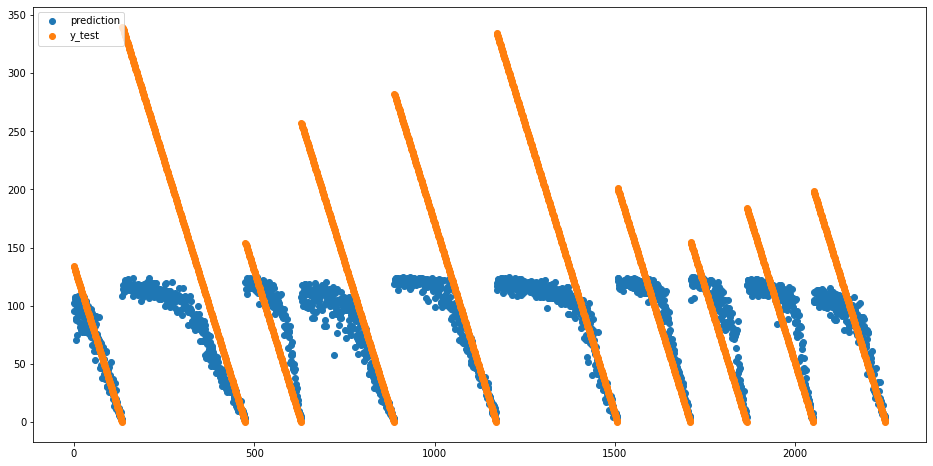

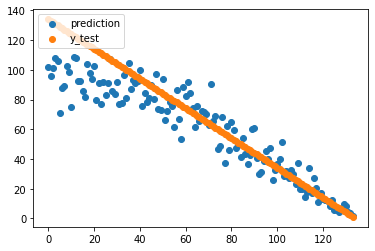

In [108]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
regressor.fit(X_train_scaled, y_train_clipped)
prediction = regressor.predict(X_test_scaled)

PrintMetrics(y_train, y_test, prediction)
ScatterPlot(prediction, y_test, len(y_test), plot_x)

## MLP

#### Compare MLP result with Regression

The multilayer perceptron is a type of artificial neural network (feedforward network) organized in multiple layers in which information flows from the input layer to the output layer. Each layer consists of a variable number of neurons.

In general, MLP results are more convincing than regression models (in this case). 

### Imports

In [109]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

### Setup

In [110]:
X_train = dataset.loc[dataset['unit number'] <= 80].drop(columns=['unit number', 'time (cycles)'])
y_train = X_train.pop('RUL')

X_test = dataset.loc[dataset['unit number'] > 80].drop(columns=['unit number', 'time (cycles)'])
y_test = X_test.pop('RUL')

plot_x = dataset.loc[dataset['unit number'] == 81].groupby('unit number').max().reset_index().drop(columns=['unit number'])['RUL'][0]

### Model

In [111]:
nb_column = X_train.shape[1]

model = Sequential()
model.add(Dense(nb_column, input_shape=(nb_column,), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_absolute_error',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 14)                210       
                                                                 
 batch_normalization_5 (Batc  (None, 14)               56        
 hNormalization)                                                 
                                                                 
 dense_26 (Dense)            (None, 32)                480       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_27 (Dense)            (None, 64)                2112      
                                                                 
 dense_28 (Dense)            (None, 128)               8320      
                                                      

### Training

In [112]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=2)

nb_epochs = 30

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = nb_epochs, shuffle = True, callbacks=[reduce_lr])

Epoch 1/30
505/505 [==============================] - 1s 1ms/step - loss: 44.5088 - accuracy: 0.0050 - val_loss: 106.4085 - val_accuracy: 0.0045 - lr: 0.0010
Epoch 2/30
505/505 [==============================] - 0s 931us/step - loss: 31.8090 - accuracy: 0.0050 - val_loss: 56.5618 - val_accuracy: 0.0045 - lr: 0.0010
Epoch 3/30
505/505 [==============================] - 0s 882us/step - loss: 31.4067 - accuracy: 0.0050 - val_loss: 550.3281 - val_accuracy: 0.0045 - lr: 0.0010
Epoch 4/30
505/505 [==============================] - 0s 910us/step - loss: 31.3318 - accuracy: 0.0050 - val_loss: 110.8491 - val_accuracy: 0.0045 - lr: 0.0010
Epoch 5/30
505/505 [==============================] - 0s 894us/step - loss: 30.6285 - accuracy: 0.0050 - val_loss: 91.3935 - val_accuracy: 0.0045 - lr: 0.0010
Epoch 6/30
505/505 [==============================] - 0s 872us/step - loss: 30.8113 - accuracy: 0.0050 - val_loss: 759.6626 - val_accuracy: 0.0045 - lr: 0.0010
Epoch 7/30
467/505 [========================

### Loss plot

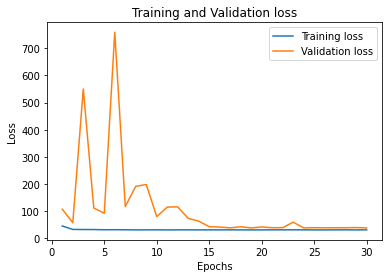

In [113]:
plt.plot(range(1, nb_epochs+1), history.history['loss'], label='Training loss')
plt.plot(range(1, nb_epochs+1), history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Sizes: test=4493 train=16138
Mean Squared Error: 2795.8398532542205
Mean Absolute Error: 37.26830126229411
function R2 Score: 0.5344248440640172


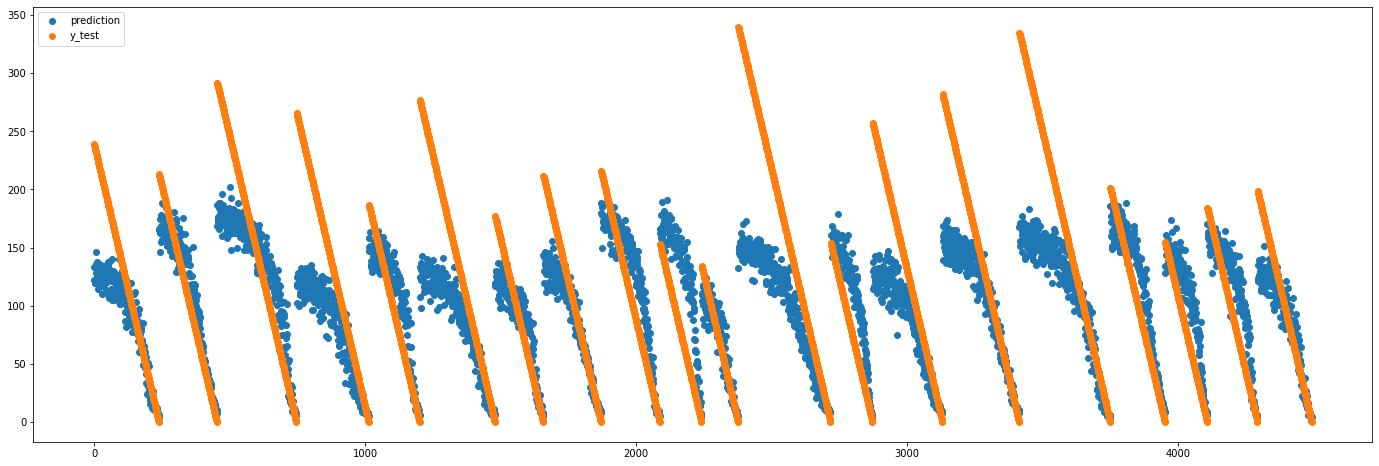

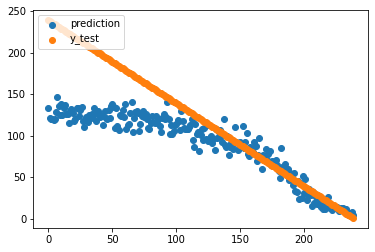

In [114]:
prediction = model.predict(X_test)

PrintMetrics(y_train, y_test, prediction)

test_size = len(y_test)

plt.figure(figsize = (24, 8))
plt.scatter(range(test_size), prediction, label="prediction")
plt.scatter(range(test_size), y_test, label="y_test")
plt.legend(loc="upper left")
plt.show()


plt.scatter(range(plot_x), prediction[0:plot_x], label="prediction")
plt.scatter(range(plot_x), y_test[0:plot_x], label="y_test")
plt.legend(loc="upper left")
plt.show()